Electric bikes are still new and changing https://www.lyft.com/bikes/bay-wheels/service-log
studies on bike share effects on cities: https://www.outsideonline.com/2136406/do-bike-share-systems-actually-work

TODO later:
- station ids and lat/long: around 450 in total, but electric only use about 330
- interpret model
- does including end_station_id mean data leakage?
- investigate closest distances farther than 1km
- EDA of target variable
- remove >4km distances from SF (about 13 are 20+km but all about the same so I'm sure there's an unlisted station somewhere)
- Include map graphic for SF and CH

As far as I can tell all the data sources have Oct/Nov of 2020 so I guess I'll use those

# minimal viable product

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

In [2]:
def grab_data(url):

    # start with data we want
    df = pd.read_csv(url, usecols=['ended_at', 'started_at', 'start_station_id', 'rideable_type',
                                   'end_station_id', 'end_lat', 'end_lng', 'member_casual'])

    # drop rows w/o lat/long coordinates
    df = df[df['end_lat'].notna()]

    # drop non-electric bikes
    df = df[df['rideable_type'] == 'electric_bike']
    df.reset_index(drop=True)
    df = df.drop(columns='rideable_type')
    
    # grab date (for data matching)
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['date'] = pd.to_datetime(df['ended_at'].dt.date)
    
    # add a few time related features
    df['hour'] = df['ended_at'].dt.hour
    
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['trip_time'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
    
    df = df.drop(columns=['ended_at', 'started_at'])
    
    # binary encoding for a few categorical features
    df['start_station_id'] = df['start_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['member_casual'] = df['member_casual'].apply(lambda x: 0 if x=='casual' else 1)
    
    return df

grab_data('data/SF/202010-baywheels-tripdata.csv')

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0
...,...,...,...,...,...,...,...,...
167535,1,SF-M15,37.765940,-122.449298,0,2020-10-27,16,710.0
167536,1,SF-M15,37.765958,-122.449482,0,2020-10-30,20,1422.0
167537,1,SF-M15,37.765931,-122.449308,0,2020-10-01,16,1433.0
167538,1,SF-M15,37.765935,-122.449313,1,2020-10-26,17,1484.0


In [45]:
def grab_geo(city):
    if city == 'SF':
        geo1 = pd.read_csv('data/SF/202010-baywheels-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
        geo2 = pd.read_csv('data/SF/202011-baywheels-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
    elif city == 'CH':
        geo1 = pd.read_csv('data/CH/202010-divvy-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
        geo2 = pd.read_csv('data/CH/202011-divvy-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
    else:
        return None
        
    geo = pd.concat([geo1, geo2], ignore_index=True).groupby(by='end_station_id').agg(np.mean)
    
    geo = geo[geo['end_lat'].notna()]
    
    return geo

In [88]:
grab_geo('SF')

,end_lat,end_lng
end_station_id,,
BK-A3,37.851376,-122.252523
BK-A7,37.880222,-122.269592
BK-B7,37.876573,-122.269528
BK-B9,37.875112,-122.260553
BK-C1,37.870407,-122.299676
...,...,...
SJ-Q5,37.311253,-121.896292
SJ-Q8,37.317234,-121.884914
SJ-Q9,37.318462,-121.883145


In [31]:
# RERUN THIS GUY if you need the station coordinates

sf = grab_data('data/SF/202010-baywheels-tripdata.csv')

# df of station lat/long indexed by station id

sf_s_geo = sf[['end_station_id', 'end_lat', 'end_lng']].groupby(by='end_station_id').agg(np.mean)

# example of how to get the lat/long out
sf_s_geo.loc['SJ-R11'] #['BK-A3']

end_lat     37.320247
end_lng   -121.870024
Name: SJ-R11, dtype: float64

In [32]:
sf_s_geo

,end_lat,end_lng
end_station_id,,
OK-L6,37.803178,-122.270921
SF I29-1,37.783516,-122.393187
SF-A19,37.805325,-122.437234
SF-A20,37.804442,-122.433609
SF-A27,37.804609,-122.403381
...,...,...
SJ-Q5,37.311235,-121.896284
SJ-Q8,37.317184,-121.884890
SJ-Q9,37.318463,-121.883134


In [22]:
stat_id = 'SJ-R11'

tuple([val for idx, val in sf_s_geo.loc[stat_id].items()])

(37.32024700833334, -121.87002400000002)

In [23]:
# geopy: calculates distance between lat/long coordinates

station_1 = 'SJ-R11'
geo_1 = tuple([val for idx, val in sf_s_geo.loc[station_1].items()])

station_2 = 'SF-A27'
geo_2 = tuple([val for idx, val in sf_s_geo.loc[station_2].items()])

geodesic(geo_1, geo_2).km

71.48788001935807

In [3]:
def station_dist(row, input_geo):
    '''Returns the distance between an input coordinate set 
    and a row coordinate set.
    
    Applied to the station coordinate dataframe, can be used 
    to make a new column of distances from a specific point
    in space.
    '''
    
    # geopy uses lat/long tuples to calculate distance
    stat_geo = tuple([val for idx, val in row.items()])
    
#     print(input_geo)
#     print(stat_geo)
    
    return geodesic(stat_geo, input_geo).km

In [4]:
def nearest_station(row, df, station_geo):
    '''doc string'''
    
    # quick progress tracker
    if row.name%2000 == 0:
        print(round(row.name/212000, 3))
    
    # get row values (I don't know a better way to do this)
    # this row expects lat/long in a specific column position
    # if df is changed beforehand the following lines will mess up
    row_vals = [val for idx, val in row.items()]
    
    # if statement to catch rows where bikes are already at a station
    if not pd.isna(row_vals[1]):
        return 0, row_vals[1]
    
    # get row lat/long
    row_geo = tuple(row_vals[2:4])
    
    # get distance to each station
    s_geo = station_geo.copy()
    s_geo['dist'] = s_geo.apply(station_dist, args=[row_geo], axis=1)
    
    # grab the minimum distance and station name
    min_id = s_geo['dist'].idxmin()
    min_dist = s_geo.at[min_id, 'dist']*1000
    
    # can return station name and distance (or just distance) in meters
    return min_dist, min_id

In [12]:
# The big computation

sf['closest_dist'], sf['closest_id'] = zip(*sf.apply(nearest_station, args=[sf], axis=1))

sf

0.0
0.009
0.018
0.027
0.036
0.045
0.054
0.063
0.072
0.081
0.09
0.126
0.162
0.18
0.189
0.198
0.234
0.243
0.252
0.261
0.27
0.279
0.288
0.315
0.333
0.351
0.36
0.387
0.396
0.405
0.423
0.432
0.441
0.45
0.459
0.486
0.495
0.505
0.514
0.523
0.532
0.559
0.568
0.577
0.613
0.631
0.649
0.658
0.667
0.676
0.694
0.703
0.712
0.721
0.73
0.748
0.766
0.784
0.802
0.811
0.82
0.829
0.838
0.856
0.865
0.883
0.892
0.901
0.91
0.919
0.928
0.946
0.955
0.964
0.973
0.982
0.991


,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [13]:
sf.to_csv('mvp.csv')

In [46]:
sf = pd.read_csv('data/mvp.csv', index_col='Unnamed: 0')

sf

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [17]:
sf.isnull().sum()

started_at              0
ended_at                0
start_station_id    27674
end_station_id      30805
end_lat                 0
end_lng                 0
member_casual           0
closest_dist            0
closest_id              0
dtype: int64

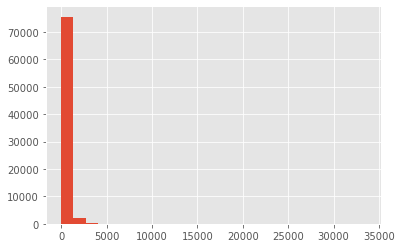

In [18]:
fig, ax = plt.subplots()

ax.hist(sf['closest_dist'], bins=25);

In [19]:
sf.describe()

,end_lat,end_lng,closest_dist
count,78358.000000,78358.000000,78358.000000
mean,37.712401,-122.350448,195.340394
std,0.153959,0.187663,555.836108
min,37.240000,-122.511290,0.000000
25%,37.759119,-122.433242,0.000000
50%,37.770359,-122.417527,0.000000
75%,37.783641,-122.398209,199.906074
max,38.050000,-121.790000,33542.857395


In [42]:
sf[sf['closest_dist'] > 0].describe()

,end_lat,end_lng,closest_dist
count,30805.000000,30805.000000,30805.000000
mean,37.651721,-122.284449,496.883059
std,0.197460,0.244932,797.532508
min,37.240000,-122.510000,33.007335
25%,37.350000,-122.440000,156.880708
50%,37.760000,-122.410000,247.967367
75%,37.780000,-121.910000,511.963177
max,38.050000,-121.790000,33542.857395


In [44]:
sf[sf['closest_dist'] > 0]

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.78,-122.42,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.80,-122.42,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.79,-122.43,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.77,-122.50,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.77,-122.49,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
109041,2021-02-03 08:38:22,2021-02-03 08:54:04,SF-K17,NaN,37.75,-122.46,member,1031.464989,SF-O12
109042,2021-02-25 09:59:31,2021-02-25 10:07:54,SF-K17,NaN,37.77,-122.47,member,403.160845,SF-J10
110571,2021-02-15 12:24:07,2021-02-15 12:28:54,SF-N23,NaN,37.75,-122.41,member,215.358834,SF-R24
110596,2021-02-20 19:27:46,2021-02-20 19:55:57,SF-N23,NaN,37.80,-122.39,member,567.660956,SF-D29


In [24]:
# pre-ML processing

X = sf.copy()

X = X.drop(columns=['started_at', 'ended_at', 'closest_id'])

X['start_station_id'] = X['start_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

X['end_station_id'] = X['end_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

X['member_casual'] = X['member_casual'].apply(lambda x: 0 if x=='casual' else 1)

scaler = StandardScaler()

X_s = scaler.fit_transform(X)

X_s

array([[-1.3533168 , -1.24244838,  0.43907207, -0.3706261 , -0.8899798 ,
        -0.02297153],
       [-1.3533168 , -1.24244838,  0.56897758, -0.3706261 , -0.8899798 ,
         0.38030297],
       [-1.3533168 , -1.24244838,  0.50402483, -0.42391351, -0.8899798 ,
         0.06010198],
       ...,
       [ 0.73892528,  0.80486241,  0.33344807, -0.34686968,  1.12362101,
        -0.35143748],
       [ 0.73892528,  0.80486241,  0.33339719, -0.34633059, -0.8899798 ,
        -0.35143748],
       [ 0.73892528,  0.80486241,  0.45866291, -0.20008063, -0.8899798 ,
        -0.35143748]])

In [25]:
X_s[:, -1:]

array([[-0.02297153],
       [ 0.38030297],
       [ 0.06010198],
       ...,
       [-0.35143748],
       [-0.35143748],
       [-0.35143748]])

In [26]:
y = X_s[:, -1:]
X_s = X_s[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X_s, y)

model = LinearRegression().fit(X_train, y_train)

In [27]:
yhat = model.predict(X_test)

# check supervised case study for metric and inference methods
mean_squared_error(y_test, yhat)

0.7161132690815011

In [29]:
X.columns

Index(['start_station_id', 'end_station_id', 'end_lat', 'end_lng',
       'member_casual', 'closest_dist'],
      dtype='object')

<BarContainer object of 5 artists>

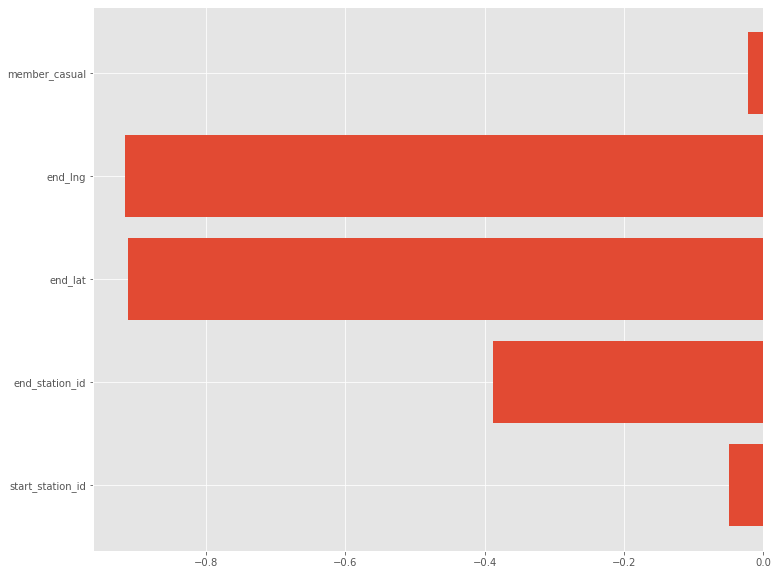

In [30]:
fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X.columns[:-1], model.coef_[0])

# Adding other data

- time (day of week)
- start/stop distance (trip distance proxy) data leakage?

In [17]:
# weather data

def grab_weather(city):
    
    if city == 'CH':
        url = 'data/CH/99733899999.csv'
    elif city == 'SF':
        url = 'data/SF/99401699999.csv'
    else:
        return None

    dfw = pd.read_csv(url, usecols=['DATE', 'TEMP', 'WDSP'])

    dfw['DATE'] = pd.to_datetime(dfw['DATE'])
    
    return dfw

grab_weather(city='CH')

,DATE,TEMP,WDSP
0,2020-01-01,30.6,17.9
1,2020-01-02,42.9,22.9
2,2020-01-03,40.1,10.4
3,2020-01-04,33.0,13.1
4,2020-01-05,32.2,18.9
...,...,...,...
360,2020-12-27,34.3,13.6
361,2020-12-28,33.7,16.5
362,2020-12-29,26.9,12.0
363,2020-12-30,32.9,20.2


In [6]:
# traffic data

def grab_traffic(city):
    
    if city == 'CH':
        dft = pd.read_csv('data/CH/CTA_-_Ridership_-_Daily_Boarding_Totals.csv',
                         usecols=['service_date', 'total_rides'])

        dft['service_date'] = pd.to_datetime(dft['service_date'])
        
        return dft
    
    elif city == 'SF':
        dft = pd.read_csv('data/SF/TaxiTable.csv')

        dft['Day of Date'] = pd.to_datetime(dft['Day of Date'])
        dft['Number of Records'] = dft['Number of Records'].replace(',', '', regex=True).astype('int32')
        dft = dft.rename(columns={'Number of Records':'taxi_trips'})
        
        return dft
    
    else:
        return None

grab_traffic('SF')

,Day of Date,taxi_trips
0,2020-09-22,7
1,2021-03-29,14
2,2020-09-23,50
3,2020-09-18,382
4,2020-03-29,1162
...,...,...
378,2020-03-13,6870
379,2020-03-12,7451
380,2020-03-11,7556
381,2020-03-10,7714


In [43]:
sf1 = grab_data('data/SF/202010-baywheels-tripdata.csv')
sf2 = grab_data('data/SF/202011-baywheels-tripdata.csv')

# df of two cities
sf = pd.concat([sf1, sf2], ignore_index=True)

# adding traffic column
sf = sf.merge(grab_traffic('SF'), how='left', left_on='date', right_on='Day of Date').drop(columns='Day of Date')

# adding weather columns
sf = sf.merge(grab_weather('SF'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data
sf = sf[sf['TEMP'].notna()]

sf

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5
...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0


In [44]:
# another BIG COMPUTATION

sf_s_geo = grab_geo('SF')

sf['closest_dist'], sf['closest_id'] = zip(*sf.apply(nearest_station, args=[sf, sf_s_geo], axis=1))

sf

0.0
0.009
0.019
0.028
0.038
0.047
0.057
0.066
0.075
0.085
0.094
0.104
0.113
0.123
0.132
0.142
0.151
0.16
0.17
0.179
0.189
0.198
0.208
0.217
0.226
0.236
0.245
0.255
0.264
0.274
0.283
0.292
0.302
0.311
0.321
0.33
0.34
0.349
0.358
0.368
0.377
0.387
0.396
0.406
0.415
0.425
0.434
0.443
0.453
0.462
0.472
0.481
0.491
0.5
0.509
0.519
0.528
0.538
0.547
0.557
0.566
0.575
0.585
0.594
0.604
0.613
0.623
0.632
0.642
0.651
0.66
0.679
0.689
0.698
0.708
0.717
0.726
0.736
0.745
0.755
0.764
0.774
0.783
0.792
0.802
0.811
0.821
0.83
0.84
0.849
0.858
0.877
0.896
0.906
0.915
0.925
0.934
0.943
0.953
0.962
0.972
0.981
0.991


,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [46]:
sf.to_csv('data/sf2.csv')

In [47]:
sf2 = pd.read_csv('data/sf2.csv', index_col='Unnamed: 0')

# drop rows w/o weather data
sf2 = sf2[sf2['TEMP'].notna()]

sf2

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [48]:
sf2.isnull().sum()

start_station_id        0
end_station_id      83428
end_lat                 0
end_lng                 0
member_casual           0
date                    0
hour                    0
trip_time               0
taxi_trips              0
TEMP                    0
WDSP                    0
closest_dist            0
closest_id              0
dtype: int64

In [49]:
X = sf2.copy()

y = X['closest_dist']
X = X.drop(columns=['end_station_id', 'date', 'closest_id', 'closest_dist'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [49]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)

X_test_s = scaler.transform(X_test)

In [50]:
model_sf = LinearRegression().fit(X_train, y_train)

yhat = model_sf.predict(X_test)

In [51]:
mean_squared_error(y_test, yhat)

225946.28459067032

In [61]:
y_base = np.ones(y_test.shape[0])*(sf2['closest_dist'].mean())

mean_squared_error(y_test, y_base)

260971.36454843456

(array([9.230e+02, 0.000e+00, 1.961e+03, 5.790e+02, 6.419e+03, 1.684e+03,
        3.950e+03, 2.175e+03, 2.353e+03, 0.000e+00, 7.830e+02, 1.929e+03,
        8.320e+02, 4.032e+03, 5.907e+03, 4.356e+03, 2.059e+03, 1.311e+03,
        0.000e+00, 3.607e+03, 3.016e+03, 0.000e+00, 1.600e+01, 8.570e+02,
        1.430e+02, 2.466e+03, 1.351e+03, 2.450e+02, 1.573e+03, 1.480e+03,
        1.897e+03, 1.798e+03, 1.810e+02, 3.090e+02, 7.900e+01, 1.617e+03,
        4.500e+02, 1.130e+02, 2.720e+02, 0.000e+00, 0.000e+00, 4.230e+02,
        7.900e+02, 0.000e+00, 7.600e+02, 1.280e+02, 3.700e+02, 4.690e+02,
        1.200e+02, 2.790e+02, 5.770e+02, 1.510e+02, 1.130e+02, 1.000e+00,
        2.550e+02, 1.100e+01, 2.820e+02, 3.850e+02, 0.000e+00, 7.320e+02]),
 array([ 29.63543652,  41.23979026,  52.84414401,  64.44849775,
         76.05285149,  87.65720523,  99.26155897, 110.86591271,
        122.47026645, 134.07462019, 145.67897393, 157.28332767,
        168.88768141, 180.49203515, 192.09638889, 203.70074264,
  

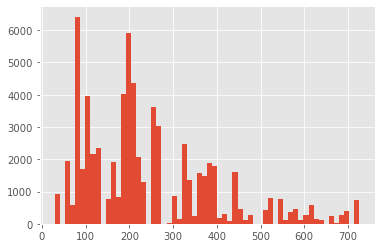

In [70]:
# graph of nearest distances that aren't 0 and less than 750m
# seem to be spikes at ~80m and ~190m, see if these are being left in a consistent location
# if they are then that's a good motivation to put a station there
# eg y>64 and y<87 and then plot all lat/long on a graph? also 180-203

fig, ax = plt.subplots()

yp = y[y>0]
yp = yp[y<750]

ax.hist(yp, bins=60)

In [104]:
y_1 = y[y > 0]

len(y_1[y_1 > 1000])/len(y_1)

0.11568058685333461

In [94]:
# among trips not docked, this is a list of stations 
# and the count of bikes nearest them and average distances from them

y_stations = sf2[sf2['closest_dist'] > 0]

y_stations = y_stations[['closest_id', 'closest_dist']]

# can sort by count or by mean, just change argument in sort_values()
y_stations = y_stations.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'mean'), ascending=False)

y_stations.merge(sf_s_geo, left_index=True, right_index=True)

/home/nicholas/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(closest_dist, mean)","(closest_dist, count)",end_lat,end_lng
BK-A7,20224.644817,13,37.880222,-122.269592
SJ-C9,3326.387676,190,37.367907,-121.918749
SF-Z6,2273.187591,793,37.722025,-122.482760
SJ-O4,2017.585223,173,37.316812,-121.910011
SF-B25,2003.103416,1,37.802732,-122.413386
...,...,...,...,...
SF-E18,70.851321,579,37.789553,-122.440575
SF-I30,63.853774,612,37.780511,-122.390333
SF-F30-2,63.483025,1158,37.789665,-122.390584
SF-S29,61.422946,191,37.750439,-122.390425


#### SF target EDA
40% of rides did not end at a docking station. Among those undocked 16% were within 100 meters of a station while 12% were more than a kilometer away from any station.

Top 5 almost docked stations and circle showing average distance away: [map](https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B1457.13%2C37.7727156%2C-122.5089787%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B78.84%2C37.3393721%2C-121.8900498%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B210.27%2C37.7881975%2C-122.4203988%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B646.2%2C37.8026239%2C-122.4359166%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B200.68%2C37.7810937%2C-122.4118281%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D) and [website](https://www.mapdevelopers.com/draw-circle-tool.php). Four in SF and one very small one in San Jose.

Looking at the station distances, there are a couple tousand within 100 meters of the nearest stations. These are not a big proportion to be sure, but could be simple fixes such as having enough docking stations, making the station itself easier to see, or keeping the app updated. It is certainly worth investigating.


In [18]:
ch1 = grab_data('data/CH/202010-divvy-tripdata.csv')
ch2 = grab_data('data/CH/202011-divvy-tripdata.csv')

# df of two cities
ch = pd.concat([ch1, ch2], ignore_index=True)

# adding traffic column
ch = ch.merge(grab_traffic('CH'), how='left', left_on='date', right_on='service_date').drop(columns='service_date')

# adding weather columns
ch = ch.merge(grab_weather('CH'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data
ch = ch[ch['TEMP'].notna()]

ch

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,total_rides,TEMP,WDSP
0,1,125.0,41.890345,-87.626068,0,2020-10-31,19,1049.0,344965.0,43.6,15.9
1,1,260.0,41.929528,-87.707818,0,2020-11-01,0,848.0,235830.0,44.7,26.7
2,1,423.0,41.791455,-87.600050,0,2020-10-31,23,501.0,344965.0,43.6,15.9
3,1,256.0,41.952809,-87.650103,0,2020-10-31,22,172.0,344965.0,43.6,15.9
4,1,185.0,41.917777,-87.691434,0,2020-10-31,19,973.0,344965.0,43.6,15.9
...,...,...,...,...,...,...,...,...,...,...,...
260305,1,261.0,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4
260306,1,134.0,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0
260307,1,134.0,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6
260308,1,623.0,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6


In [20]:
sf2.describe()

,start_station_id,end_lat,end_lng,member_casual,hour,trip_time,taxi_trips,TEMP,WDSP,PRCP,closest_dist
count,208828.000000,208828.000000,208828.000000,208828.000000,208828.000000,208828.000000,208828.000000,208828.000000,208828.000000,208828.0,208828.000000
mean,0.627761,37.720085,-122.360549,0.400320,14.209110,976.903610,3594.400033,57.416802,4.919349,0.0,195.207985
std,0.483403,0.145957,0.178700,0.489964,4.616213,1111.205928,639.841474,5.113415,1.821421,0.0,529.390818
min,0.000000,37.240000,-122.520000,0.000000,0.000000,-3243.000000,2011.000000,50.000000,1.500000,0.0,0.000000
25%,0.000000,37.760000,-122.435400,0.000000,11.000000,407.000000,3125.000000,53.100000,3.900000,0.0,0.000000
50%,1.000000,37.771934,-122.420000,0.000000,15.000000,685.000000,3852.000000,57.200000,4.500000,0.0,0.000000
75%,1.000000,37.784096,-122.400000,1.000000,17.000000,1137.000000,4072.000000,59.600000,5.600000,0.0,199.654258
max,1.000000,38.050000,-121.800000,1.000000,23.000000,28800.000000,4647.000000,73.300000,12.700000,0.0,28538.474645


In [24]:
sf3 = sf2[sf2['closest_dist'] > 0].sort_values(by='closest_dist')

sf3.describe()

,start_station_id,end_lat,end_lng,member_casual,hour,trip_time,taxi_trips,TEMP,WDSP,PRCP,closest_dist
count,83428.000000,83428.000000,83428.000000,83428.000000,83428.000000,83428.000000,83428.000000,83428.000000,83428.000000,83428.0,83428.000000
mean,0.438318,37.673958,-122.312570,0.315506,14.331855,1051.875294,3576.194587,57.540764,4.910938,0.0,488.623639
std,0.496184,0.184994,0.230737,0.464720,4.736612,1361.635745,646.831041,5.225855,1.810883,0.0,747.085527
min,0.000000,37.240000,-122.520000,0.000000,0.000000,-3243.000000,2011.000000,50.000000,1.500000,0.0,27.496301
25%,0.000000,37.730000,-122.440000,0.000000,12.000000,367.000000,3048.000000,53.100000,3.900000,0.0,157.296553
50%,0.000000,37.770000,-122.420000,0.000000,15.000000,676.000000,3834.000000,57.200000,4.500000,0.0,251.816098
75%,1.000000,37.780000,-122.390000,1.000000,18.000000,1248.000000,4035.000000,59.600000,5.600000,0.0,511.978715
max,1.000000,38.050000,-121.800000,1.000000,23.000000,28800.000000,4647.000000,73.300000,12.700000,0.0,28538.474645


In [29]:
sf3.iloc[-50:, :]

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,PRCP,closest_dist,closest_id
187333,1,NaN,37.86,-122.48,0,2020-11-15,13,4676.0,2347,51.7,2.8,0.0,7141.476701,SF-A19
156178,0,NaN,37.86,-122.48,0,2020-11-02,13,5707.0,4202,58.0,3.0,0.0,7141.476701,SF-A19
201292,1,NaN,37.86,-122.48,0,2020-11-01,13,3884.0,2871,59.3,4.3,0.0,7141.476701,SF-A19
11152,0,NaN,37.86,-122.48,0,2020-10-25,16,6497.0,2505,57.3,4.6,0.0,7141.476701,SF-A19
201452,1,NaN,37.86,-122.48,0,2020-11-26,13,11554.0,2011,54.3,9.3,0.0,7141.476701,SF-A19
186480,1,NaN,37.86,-122.48,0,2020-11-07,15,11931.0,3302,52.8,4.5,0.0,7141.476701,SF-A19
187616,1,NaN,37.86,-122.48,0,2020-11-15,13,5885.0,2347,51.7,2.8,0.0,7141.476701,SF-A19
56378,1,NaN,37.86,-122.48,0,2020-10-11,14,7725.0,2612,60.1,5.3,0.0,7141.476701,SF-A19
109657,1,NaN,37.86,-122.48,0,2020-10-02,16,6754.0,4647,63.4,3.9,0.0,7141.476701,SF-A19
109660,1,NaN,37.86,-122.48,0,2020-10-02,16,6766.0,4647,63.4,3.9,0.0,7141.476701,SF-A19


In [30]:
sf2[sf2['closest_dist'] > 1000]

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,PRCP,closest_dist,closest_id
11,0,NaN,37.74,-122.51,0,2020-10-30,18,615.0,4483,54.1,5.5,0.0,3117.137940,SF-Z6
12,0,NaN,37.75,-122.51,0,2020-10-30,18,826.0,4483,54.1,5.5,0.0,2542.214578,SF-J1
23,0,NaN,37.74,-122.49,0,2020-10-21,20,740.0,3997,58.0,5.0,0.0,1561.045263,SF-W8
40,0,NaN,37.75,-122.49,0,2020-10-10,15,1747.0,3125,59.7,4.4,0.0,2312.436511,SF-M10
51,0,NaN,37.76,-122.50,0,2020-10-11,20,5307.0,2612,60.1,5.3,0.0,1634.386331,SF-J1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210061,1,NaN,37.80,-122.45,1,2020-11-08,14,757.0,2491,52.6,10.3,0.0,1243.272475,SF-B19
210063,1,NaN,37.80,-122.45,1,2020-11-03,6,660.0,4250,54.7,6.9,0.0,1243.272475,SF-B19
210064,1,NaN,37.80,-122.45,1,2020-11-07,11,813.0,3302,52.8,4.5,0.0,1243.272475,SF-B19
210065,1,NaN,37.80,-122.45,1,2020-11-02,6,718.0,4202,58.0,3.0,0.0,1243.272475,SF-B19
